## Deep Learning Term Project for ECG (DIL700)

# Iteration 5 - Just for test

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from keras import Sequential
from keras.layers import Convolution1D, MaxPool1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

import datetime

# Custom functions
from general_functions import *

# Loading dataset

    Number of Samples: 14552
    Number of Categories: 2
    Sampling Frequency: 125Hz
    Data Source: Physionet's PTB Diagnostic Database

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs. (https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [2]:
normal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_normal.csv',header=None)
abnormal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_abnormal.csv',header=None)
# Combine to a full dataset
full_df = pd.concat([normal_df, abnormal_df], axis=0, ignore_index=True)

In [3]:
print('Number of samples per class: \n')
print('Normal:                 ', len(full_df[full_df[187]==0]))
print('Abnormal:               ', len(full_df[full_df[187]==1]))

Number of samples per class: 

Normal:                  4046
Abnormal:                10506


In [4]:
normal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Normal only contains class 0 --> healthy
normal_df[187].unique()

array([0.])

In [6]:
abnormal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# Abnormal only contains class 1 --> not healthy
abnormal_df[187].unique()

array([1.])

In [8]:
full_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14547,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14548,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14549,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14550,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# Full contains both classes
full_df[187].unique()

array([0., 1.])

In [10]:
labels = ['Normal', 'Abnormal']

# Preparation

In [11]:
from sklearn.model_selection import train_test_split

# split the data into features and target
X = full_df.drop(187, axis=1)
y = full_df[187]

# Split data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [12]:
# validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42)

In [13]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.052197,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [14]:
train_df = X_train.copy()
train_df[187] = y_train
valid_df = X_valid.copy()
valid_df[187] = y_valid
test_df = X_test.copy()	
test_df[187] = y_test

train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


In [15]:
print('Number of samples in training data:')
print('Normal:                              ', len(train_df[train_df[187]==0]))
print('Abnormal:                            ', len(train_df[train_df[187]==1]))

Number of samples in training data:
Normal:                               2589
Abnormal:                             6723


In [16]:
print('Number of samples in validation data:')
print('Normal:                              ', len(valid_df[valid_df[187]==0]))
print('Abnormal:                            ', len(valid_df[valid_df[187]==1]))

Number of samples in validation data:
Normal:                               648
Abnormal:                             1681


In [17]:
print('Number of samples in test data:')
print('Normal:                              ', len(test_df[test_df[187]==0]))
print('Abnormal:                            ', len(test_df[test_df[187]==1]))

Number of samples in test data:
Normal:                               809
Abnormal:                             2102


Same ratio of the two classes in both the datasets

# LSTM

In [23]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the model
model = Sequential()

# Add the LSTM layers
model.add(LSTM(64, return_sequences=True, input_shape=(187, 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/4
291/291 [==============================] - 57s 184ms/step - loss: 0.5448 - accuracy: 0.7249 - val_loss: 0.5413 - val_accuracy: 0.7201
Epoch 2/4
291/291 [==============================] - 51s 176ms/step - loss: 0.5193 - accuracy: 0.7319 - val_loss: 0.5364 - val_accuracy: 0.7235
Epoch 3/4
291/291 [==============================] - 52s 177ms/step - loss: 0.5057 - accuracy: 0.7253 - val_loss: 0.4792 - val_accuracy: 0.7372
Epoch 4/4
291/291 [==============================] - 51s 177ms/step - loss: 0.5269 - accuracy: 0.7253 - val_loss: 0.4955 - val_accuracy: 0.7192


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

X_train_arr = X_train.to_numpy()
X_valid_arr = X_valid.to_numpy()
y_train_arr = y_train.to_numpy()
y_valid_arr = y_valid.to_numpy()

# Reshape the signals array to have a 3D shape for the LSTM input
X_train_res = np.reshape(X_train_arr, (X_train_arr.shape[0], X_train_arr.shape[1], 1))

# Reshape the signals array to have a 3D shape for the LSTM input
X_valid_res = np.reshape(X_valid_arr, (X_valid_arr.shape[0], X_valid_arr.shape[1], 1))

# Define the model
model = Sequential()

# Add the LSTM layers
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_res.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dropout(0.1))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_res, y_train_arr, epochs=4, batch_size=32, validation_data=(X_valid_res, y_valid_arr))

Epoch 1/4
291/291 [==============================] - 55s 178ms/step - loss: 0.5523 - accuracy: 0.7205 - val_loss: 0.5140 - val_accuracy: 0.7218
Epoch 2/4
291/291 [==============================] - 51s 174ms/step - loss: 0.5183 - accuracy: 0.7298 - val_loss: 0.4983 - val_accuracy: 0.7381
Epoch 3/4
291/291 [==============================] - 52s 180ms/step - loss: 0.5119 - accuracy: 0.7242 - val_loss: 0.5205 - val_accuracy: 0.7218
Epoch 4/4
291/291 [==============================] - 52s 180ms/step - loss: 0.5060 - accuracy: 0.7360 - val_loss: 0.5145 - val_accuracy: 0.7527


In [62]:
# create the model
model = Sequential()
model.add(Embedding(100, 32, input_length=187))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=4, batch_size=64)

Epoch 1/4
146/146 [==============================] - 15s 91ms/step - loss: 0.5981 - accuracy: 0.7188 - val_loss: 0.5914 - val_accuracy: 0.7218
Epoch 2/4
146/146 [==============================] - 13s 88ms/step - loss: 0.5927 - accuracy: 0.7220 - val_loss: 0.5918 - val_accuracy: 0.7218
Epoch 3/4
146/146 [==============================] - 13s 89ms/step - loss: 0.5919 - accuracy: 0.7220 - val_loss: 0.5914 - val_accuracy: 0.7218
Epoch 4/4
146/146 [==============================] - 14s 95ms/step - loss: 0.5919 - accuracy: 0.7220 - val_loss: 0.5915 - val_accuracy: 0.7218


# Working

The 0's in the end of the columsn seem to be the cause of the model not learning correctly

In [18]:
X_train_short = X_train.iloc[:, : 50]
X_valid_short = X_valid.iloc[:, : 50]
X_train_short

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.132908,0.141246,0.136341,0.145660,0.130947,0.129966,0.143207,0.157921,0.175086,0.212849
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.125519,0.128631,0.137967,0.125000,0.131743,0.125519,0.135373,0.135373,0.118257,0.124481
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.020859,0.028643,0.033001,0.031756,0.047011,0.034558,0.039228,0.042653,0.036115,0.035492
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.367986,0.337973,0.296216,0.254458,0.212701,0.175729,0.144411,0.120487,0.106568,0.093954
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.387201,0.372334,0.353588,0.376212,0.361345,0.356820,0.361991,0.362637,0.379444,0.373626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.300118,0.282429,0.299528,0.290094,0.283019,0.320165,0.296580,0.307193,0.299528,0.288325
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.673854,0.673854,0.641509,0.648697,0.695418,0.615454,0.653190,0.637916,0.626235,0.589398
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.377518,0.341257,0.296535,0.244964,0.198630,0.163175,0.133360,0.109589,0.094682,0.082595
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.089977,0.103497,0.140326,0.112354,0.117016,0.091375,0.100233,0.112354,0.081585,0.096970


In [19]:
# LSTM Jesper
# Find optimal number of data length to input for LSTM --> look for distribution of data length (when do the 0's begin)
# more layers
# change regularization

# Model without arrays and reshaping

In [20]:
name = 'lstm_test_2'

In [21]:
X_train_short = X_train.iloc[:, : 50]
X_valid_short = X_valid.iloc[:, : 50]
X_train_short

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.132908,0.141246,0.136341,0.145660,0.130947,0.129966,0.143207,0.157921,0.175086,0.212849
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.125519,0.128631,0.137967,0.125000,0.131743,0.125519,0.135373,0.135373,0.118257,0.124481
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.020859,0.028643,0.033001,0.031756,0.047011,0.034558,0.039228,0.042653,0.036115,0.035492
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.367986,0.337973,0.296216,0.254458,0.212701,0.175729,0.144411,0.120487,0.106568,0.093954
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.387201,0.372334,0.353588,0.376212,0.361345,0.356820,0.361991,0.362637,0.379444,0.373626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.300118,0.282429,0.299528,0.290094,0.283019,0.320165,0.296580,0.307193,0.299528,0.288325
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.673854,0.673854,0.641509,0.648697,0.695418,0.615454,0.653190,0.637916,0.626235,0.589398
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.377518,0.341257,0.296535,0.244964,0.198630,0.163175,0.133360,0.109589,0.094682,0.082595
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.089977,0.103497,0.140326,0.112354,0.117016,0.091375,0.100233,0.112354,0.081585,0.096970


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential()

# Add the LSTM layers
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_short.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dropout(0.1))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# Train the model
history = model.fit(X_train_short, y_train, epochs=100, callbacks=callbacks, batch_size=32, validation_data=(X_valid_short, y_valid))

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 19s 51ms/step - loss: 0.4975 - accuracy: 0.7410 - val_loss: 0.3983 - val_accuracy: 0.7888
Epoch 2/100
291/291 [==============================] - 13s 46ms/step - loss: 0.3914 - accuracy: 0.8012 - val_loss: 0.3708 - val_accuracy: 0.8248
Epoch 3/100
291/291 [==============================] - 13s 46ms/step - loss: 0.3743 - accuracy: 0.8077 - val_loss: 0.3374 - val_accuracy: 0.8471
Epoch 4/100
291/291 [==============================] - 14s 47ms/step - loss: 0.3474 - accuracy: 0.8281 - val_loss: 0.3590 - val_accuracy: 0.8051
Epoch 5/100
291/291 [==============================] - 14s 47ms/step - loss: 0.3254 - accuracy: 0.8342 - val_loss: 0.2949 - val_accuracy: 0.8656
Epoch 6/100
291/291 [==============================] - 14s 47ms/step - loss: 0.2988 - accuracy: 0.8555 - val_loss: 0.2914 - val_accuracy: 0.8587
Epoch 7/100
291/291 [==============================] - 14s 46ms/step - loss: 0.2829 - accuracy: 0.8638 - val_loss: 0.2776 - val_ac

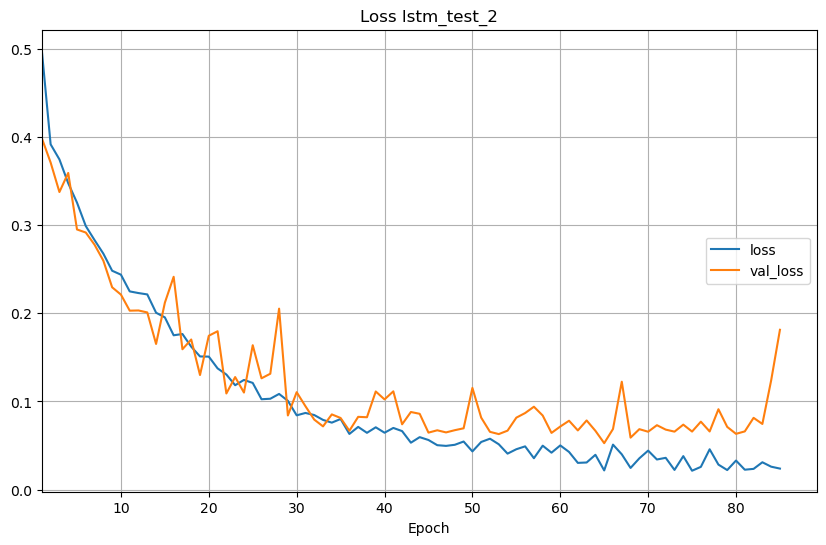

In [23]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

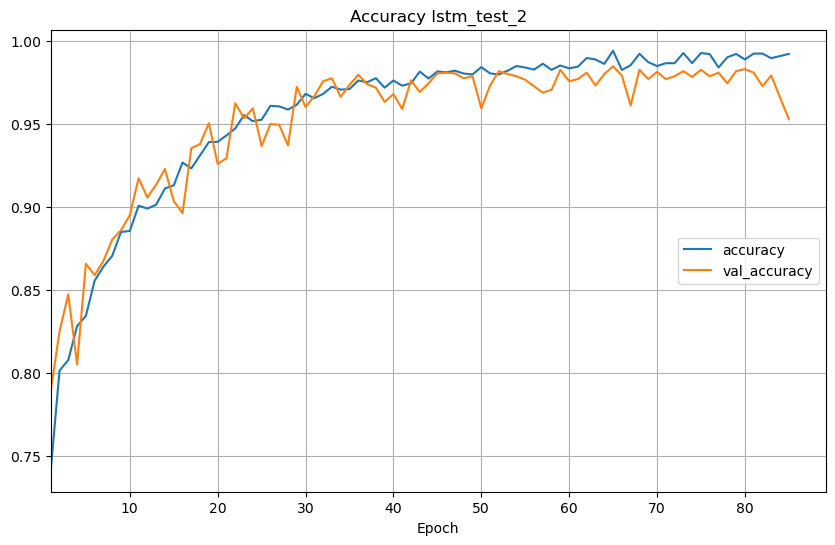

In [24]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [25]:
X_test_short = X_test.iloc[:, : 50]

In [26]:
# Predict test set labels
y_pred_proba = model.predict(X_test_short)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 3s 15ms/step
Accuracy: 0.98385


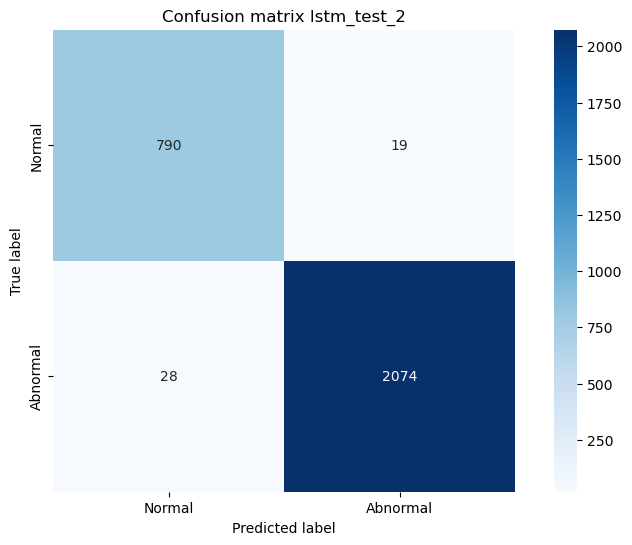

In [27]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [28]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9658    0.9765    0.9711       809
    Abnormal     0.9909    0.9867    0.9888      2102

    accuracy                         0.9839      2911
   macro avg     0.9783    0.9816    0.9800      2911
weighted avg     0.9839    0.9839    0.9839      2911



In [29]:
# error cell prevent old from running

izgib

NameError: name 'izgib' is not defined

# OLD: model with reshaping and arrays

In [ ]:
name = 'lstm_test'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

X_train_arr = X_train_short.to_numpy()
X_valid_arr = X_valid_short.to_numpy()
y_train_arr = y_train.to_numpy()
y_valid_arr = y_valid.to_numpy()

# Reshape the signals array to have a 3D shape for the LSTM input
X_train_res = np.reshape(X_train_arr, (X_train_arr.shape[0], X_train_arr.shape[1], 1))

# Reshape the signals array to have a 3D shape for the LSTM input
X_valid_res = np.reshape(X_valid_arr, (X_valid_arr.shape[0], X_valid_arr.shape[1], 1))

# Define the model
model = Sequential()

# Add the LSTM layers
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_res.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dropout(0.1))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]


# Train the model
history = model.fit(X_train_res, y_train_arr, epochs=50, callbacks=callbacks, batch_size=32, validation_data=(X_valid_res, y_valid_arr))

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/50
291/291 [==============================] - 17s 44ms/step - loss: 0.4821 - accuracy: 0.7558 - val_loss: 0.4033 - val_accuracy: 0.7995
Epoch 2/50
291/291 [==============================] - 12s 41ms/step - loss: 0.3976 - accuracy: 0.7905 - val_loss: 0.3419 - val_accuracy: 0.8398
Epoch 3/50
291/291 [==============================] - 12s 40ms/step - loss: 0.3630 - accuracy: 0.8106 - val_loss: 0.3624 - val_accuracy: 0.8261
Epoch 4/50
291/291 [==============================] - 12s 41ms/step - loss: 0.3387 - accuracy: 0.8288 - val_loss: 0.3671 - val_accuracy: 0.8218
Epoch 5/50
291/291 [==============================] - 12s 40ms/step - loss: 0.3268 - accuracy: 0.8372 - val_loss: 0.2934 - val_accuracy: 0.8725
Epoch 6/50
291/291 [==============================] - 12s 40ms/step - loss: 0.3184 - accuracy: 0.8403 - val_loss: 0.2778 - val_accuracy: 0.8720
Epoch 7/50
291/291 [==============================] - 12s 40ms/step - loss: 0.2785 - accuracy: 0.8669 - val_loss: 0.2652 - val_accuracy:

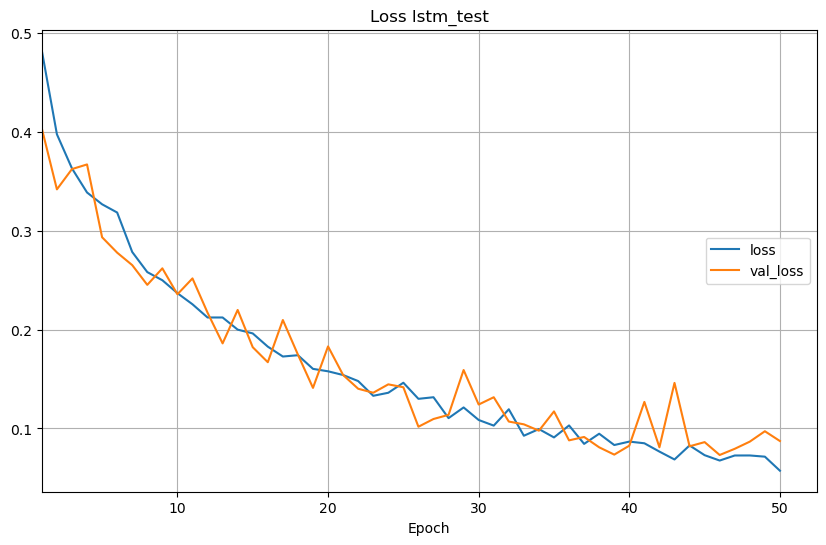

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

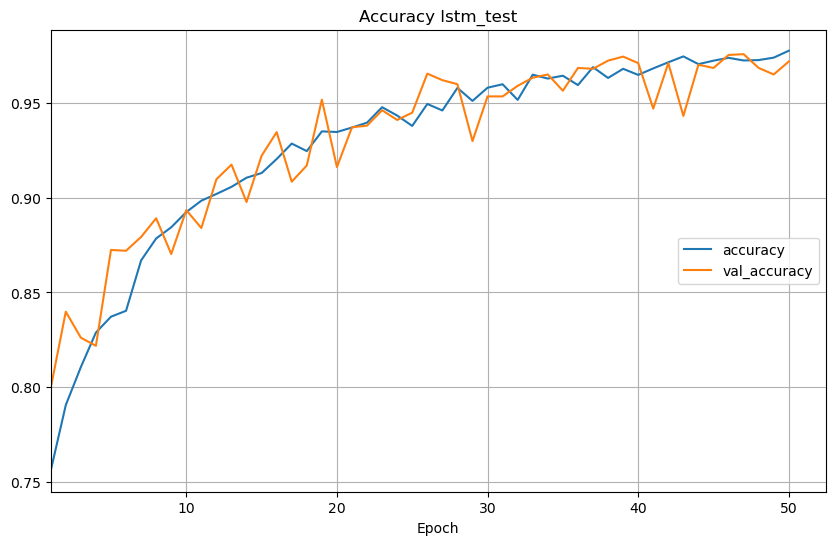

In [ ]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [ ]:
X_test_short = X_test.iloc[:, : 50]

In [ ]:
X_test_arr = X_test_short.to_numpy()
y_test_arr = y_test.to_numpy()

# Reshape the signals array to have a 3D shape for the LSTM input
X_test_res = np.reshape(X_test_arr, (X_test_arr.shape[0], X_test_arr.shape[1], 1))

In [ ]:
# Predict test set labels
y_pred_proba = model.predict(X_test_res)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test_arr, y_pred):.5f}')

91/91 [==============================] - 2s 14ms/step
Accuracy: 0.97836


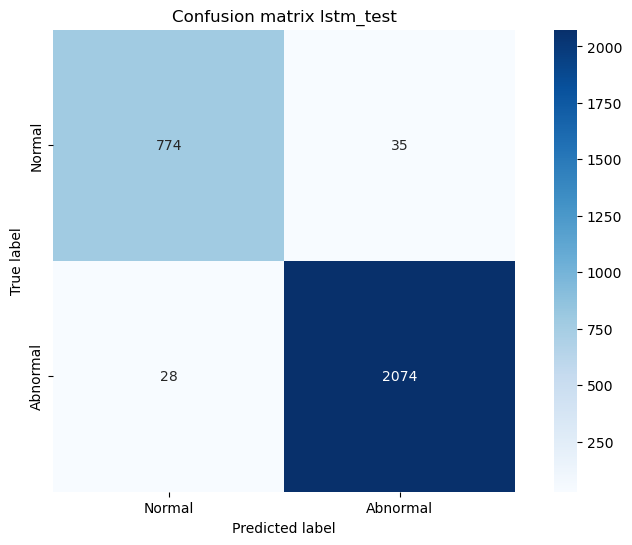

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_arr, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
print(classification_report(y_test_arr, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9651    0.9567    0.9609       809
    Abnormal     0.9834    0.9867    0.9850      2102

    accuracy                         0.9784      2911
   macro avg     0.9742    0.9717    0.9730      2911
weighted avg     0.9783    0.9784    0.9783      2911

